In [7]:
from skimage import io, draw as d
import drawSvg as draw
from skimage.transform import rescale
from matplotlib import pyplot as plt
import numpy as np
from random import random,shuffle
from math import pi, sin,cos,inf

In [17]:
default_angles = np.arange(0, 4) * pi/2 + .21

def rand_point(h, w, spacing):
    rand_y= ((random() * h) // spacing) * spacing
    rand_x = ((random() * w) // spacing) * spacing
    return map(int, [rand_y, rand_x])

def rmse(img, approx):
    return ((img - approx)**2).sum()**.5

def mean_gain(curr, img, sx, sy, ex, ey, modifier=1, scaling=1):
    sx, sy, ex, ey = map(lambda x: int(x*scaling), [sx,sy,ex, ey])
    rr, cc, val = d.line_aa(sx, sy, ex, ey)
    val *= modifier
    curr = curr[rr, cc]
    base = img[rr, cc]
    new = curr + val
    new = np.minimum(new, 1)
    curr_err = ((base - curr)**2).sum()**.5
    new_err = ((base - new)**2).sum()**.5
    return (curr_err - new_err) / len(val)

def sketch(path, angles=default_angles):
    img = 1-rescale(io.imread(path, as_gray=True), .25)
    h, w = img.shape
    canvas = np.zeros(img.shape)
    ones = np.ones(img.shape)
    io.imshow(canvas)
    length = (w**2 + h**2)**.5
    lines=[]
    modifier = 1.5
    scaling=1
    spacing = 5
    for i in range(2000):
        if i in {100, 1000, 1500}:
            modifier *= .5
            scaling *= .5
            img = rescale(img, .5)
            canvas = rescale(canvas, .5)
            spacing *= 2
        seen = set()
        # print(i, modifier)
        y, x = rand_point(h, w, spacing)
        line = [x, y]
        count = 0
        while True:
            count += 1
            best_gain = 0
            bestcoords = (None, None)
            shuffle(angles)
            for ang in angles:
                dy, dx = sin(ang), cos(ang)
                for l in np.array([1/12, 1/8, 1/6, 1/4, 1/3.5, 1/3, 1/2.5, 1/2, 1]) * length//8:
                    ey, ex = y+l*dy, x+l*dx
                    if ey < 0 or ex < 0:
                        continue
                    if ey >= h or ex >= w:
                        continue
                    gain = mean_gain(canvas, img, int(x), int(y), int(ex), int(ey), modifier, scaling)
                    if gain > best_gain and (int(x), int(y), int(ex), int(ey)) not in seen:
                        best_gain = gain
                        bestcoords = ey, ex
            if best_gain <= 0.0:
                break
            line_def = tuple(map(int, [bestcoords[1], bestcoords[0], ey, ex]))
            if line_def in seen:
                break
            seen.add(line_def)
            sx, sy, ex,ey = map(lambda x: int(x*scaling), [x,y,bestcoords[1], bestcoords[0]])
            rr, cc, val = d.line_aa(sx, sy, ex, ey)
            canvas[rr, cc] += val * modifier
            canvas = np.minimum(canvas, 1)
            y, x = bestcoords
            line.extend((x, y))
        lines.append(line)
        # print('>', count)
    io.imshow(canvas)
    return lines
    

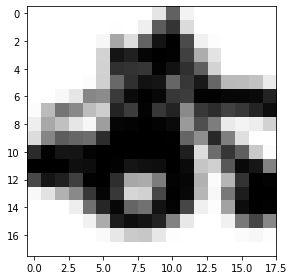

In [9]:
lines = sketch('/home/chriskw/Pictures/debugdog2.jpg')

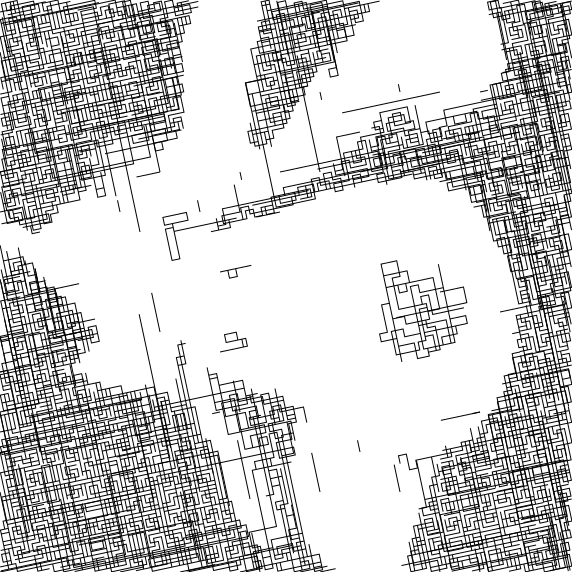

In [14]:
def draw_lines(lines, path):
    img = rescale(io.imread(path, as_gray=True), 1)
    h, w = img.shape
    canvas = draw.Drawing(w, h)
    for line in lines:
        if len(line) > 2:
            line = 4 * np.array(line)
            canvas.append(draw.Lines(*line, fill='none', stroke='black', close=False))
    return canvas
    
draw_lines(lines, '/home/chriskw/Pictures/debugdog2.jpg')

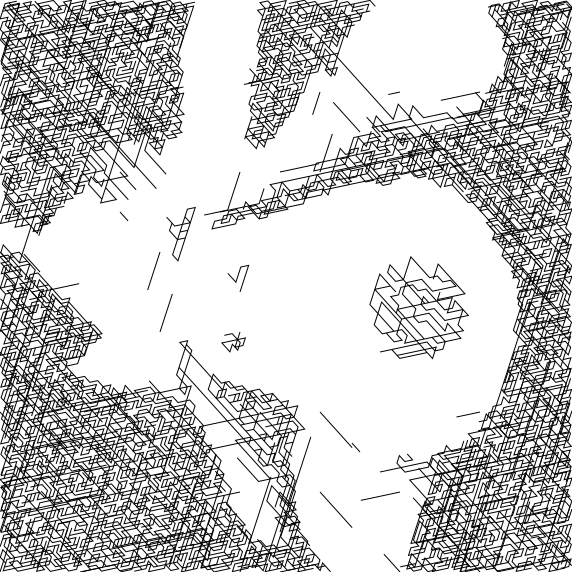

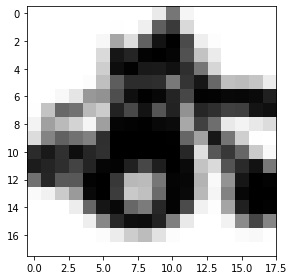

In [18]:
lines = sketch('/home/chriskw/Pictures/debugdog2.jpg',angles=np.arange(0, 6) * pi/3 + .21)
draw_lines(lines, '/home/chriskw/Pictures/debugdog2.jpg')